# Imports

In [4]:
import jax 
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import optax

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".5"
px = 1/plt.rcParams["figure.dpi"]

# Data Preprocessing

In [5]:
# MNIST dataset, already flat and normalized
X_train_1 = jnp.load('../mnist_np/X_train_1.npy') 
X_train_2 = jnp.load('../mnist_np/X_train_2.npy') 
X_train_3 = jnp.load('../mnist_np/X_train_3.npy') 
X_train_4 = jnp.load('../mnist_np/X_train_4.npy') 
# create X_train out of 4 X_trains
X_train = jnp.concatenate([X_train_1, X_train_2, X_train_3, X_train_4], axis=0)
y_train = jnp.load('../mnist_np/y_train.npy')
X_test = jnp.load('../mnist_np/X_test.npy')
y_test = jnp.load('../mnist_np/y_test.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(60000, 784) (60000,) (10000, 784) (10000,)


In [6]:
def rate_encoding(key, X, sim_len=100):
    
    def bernoulli_encoding(key, spike_trains, sim_len):
        key, subkey = jax.random.split(key)
        return key, jax.random.bernoulli(key, spike_trains, (sim_len, spike_trains.shape[0], spike_trains.shape[1]))
    
    print('Encoding the data in batches of 2000 (going above take more time)')
    X_encoded = []
    batch_size = 2000
    for i in range(X.shape[0]//batch_size):
        key, X_encoded_ = bernoulli_encoding(key, X[i*batch_size:(i+1)*batch_size], sim_len=100)
        print(X_encoded_.shape)
        X_encoded.append(X_encoded_)

    return key, jnp.concatenate(X_encoded, axis=1)

# do rate encoding on X_test
key = jax.random.PRNGKey(9)
key, X_test_encoded = rate_encoding(key, X_test, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


In [7]:
# do rate encoding on Xtrain
key, X_train_encoded = rate_encoding(key, X_train, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


# Function Definition

In [8]:
@jax.custom_jvp
def gr_than(x, thr):
    return (x > thr).astype(jnp.float32)

@gr_than.defjvp
def gr_jvp(primals, tangents):
    x, thr = primals
    x_dot, thr_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot * 1 / (jnp.absolute(x-thr)+1)**2
    return primal_out, tangent_out

def lif_forward(state, input_spikes):
    params, hidden_spikes, out_spikes2, I_in, V_mem1, V_mem2 = state[0]
    tau_mem, Vth, timestep = state[1]
    W01 = params[0]
    W11 = params[1]
    W12 = params[2]
    
    # Layer 1
    I_in = jnp.dot(W01, input_spikes) # shape (8,1)
    # recurrent connection
    I_rec = jnp.dot(W11, hidden_spikes) # shape (8,1)
    V_mem1 = (1 - timestep/tau_mem) * V_mem1 + I_rec + I_in - hidden_spikes * Vth
    # constraining V_mem to be non-negative
    V_mem1 = jnp.maximum(0, V_mem1)
    hidden_spikes = gr_than(V_mem1, Vth)
    # Layer 2
    I_in2 = jnp.dot(W12, hidden_spikes)
    V_mem2 = (1 - timestep/tau_mem) * V_mem2 + I_in2 # no reset, just integrate
    # constraining V_mem to be non-negative
    V_mem2 = jnp.maximum(0, V_mem2)
    out_spikes2 = gr_than(V_mem2, Vth)
    # return state
    return ((params, hidden_spikes, out_spikes2, I_in, V_mem1, V_mem2), state[1]), (I_in, V_mem1, V_mem2, out_spikes2)


In [9]:
def randomWeightInit(parent_key, scale, in_width, out_width):
    in_width = in_width
    out_width = out_width
    weight_key, bias_key = jax.random.split(parent_key)
    W = scale*jax.random.normal(weight_key, shape=(out_width, in_width))
    return W

In [10]:
def mini_loss(params, static_params, img, lbl):
    num_classes = params[2].shape[0]
    num_hidden = params[1].shape[0]
    
    V_mem1 = jnp.zeros((num_hidden,), dtype='float32')
    I_in = jnp.zeros((num_hidden,), dtype='float32')
    hidden_spikes = jnp.zeros((num_hidden,), dtype='float32')
    V_mem2 = jnp.zeros((num_classes,), dtype='float32')
    out_spikes = jnp.zeros((num_classes,), dtype='float32')
    state = ((params, hidden_spikes, out_spikes, I_in, V_mem1, V_mem2), static_params)

    state, plot_values = jax.lax.scan(lif_forward,state,img)

    V_mem_data = plot_values[2]
    max_per_class = V_mem_data.max(axis=0)
    prediction = max_per_class.argmax()
    logits = jax.nn.softmax(max_per_class)
    loss = -jnp.mean(jnp.log(logits[lbl.astype(jnp.uint8)]))
    acc = jnp.where(prediction == lbl, 1.0, 0.0)

    return loss, acc

In [11]:
# loss function
def loss_fn_vmap(params, static_params, img_b, lbl_b):
    batch_size = img_b.shape[0]
    
    local_loss = jnp.zeros(batch_size)
    local_acc = jnp.zeros(batch_size)

    local_loss, local_acc = jax.vmap(mini_loss, in_axes=(None, None, 0, 0))(params, static_params, img_b, lbl_b)
    return local_loss.mean(), local_acc.mean()

## Dataset class

In [12]:
class MNISTDataset():
    def __init__(self, X_images,Y_labels):
        self.imgs = X_images
        self.lbls = Y_labels
    def __len__(self): 
        return self.imgs.shape[1]

    def __getitem__(self, idx):
        return self.imgs[:,idx,:], self.lbls[idx]

In [13]:
class MNISTDataset_unencoded():
    def __init__(self, X_images,Y_labels):
        self.imgs = X_images
        self.lbls = Y_labels
    def __len__(self): 
        return self.lbls.shape[0]

    def __getitem__(self, idx):
        return self.imgs[idx], self.lbls[idx]

In [14]:
train_dataset = MNISTDataset(X_train_encoded, y_train)
test_dataset = MNISTDataset(X_test_encoded, y_test)

train_dataset_unencoded = MNISTDataset_unencoded(X_train, y_train)
test_dataset_unencoded = MNISTDataset_unencoded(X_test, y_test)

## Dataloader

In [15]:
from torch.utils.data import DataLoader

batch_size=128

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels= np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

train_loader_unencoded = DataLoader(train_dataset_unencoded, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader_unencoded = DataLoader(test_dataset_unencoded, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# Training SNN

## Initialization of loop

In [17]:
num_classes = 10
num_hidden = 200

# initialize state variables of LIF neuron for every time step

# initialize dynamic params

seed = 9
parent_key = jax.random.PRNGKey(seed)
W01 = randomWeightInit(parent_key, 0.03, 784, num_hidden)
W11 = randomWeightInit(parent_key, 0.03, num_hidden, num_hidden)
W12 = randomWeightInit(parent_key, 0.03, num_hidden, num_classes)
params = [W01, W11, W12]
params_init = params

tau_mem = 10e-3
V_th = 1.0
timestep = 1e-3

static_params = (tau_mem, V_th, timestep)

In [18]:
# optimizer with scheduler

start_learning_rate = 1e-3
n_epochs = 1
hp = static_params

n_batches = len(train_loader)
n_updates = n_epochs * n_batches
n_updates_lr = 15
transition_steps = np.floor(n_updates / n_updates_lr)
print(f'n_updates: {n_updates}, n_updates_lr: {n_updates_lr}, transition_steps: {transition_steps}')

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=transition_steps,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = gradient_transform.init(params)

n_updates: 468, n_updates_lr: 15, transition_steps: 31.0


## Training Loop 

In [20]:
num_epochs = 2
best_acc = 0.5

for epoch in range(num_epochs):
    epoch_loss = jnp.zeros(len(train_loader))
    epoch_acc = jnp.zeros(len(train_loader))
    # continue training for one whole epoch using mini loss
    for batch_cnt, (img_batch, lbl_batch) in enumerate(train_loader):
      (batch_loss, batch_acc), weight_grad = jax.value_and_grad(loss_fn_vmap, has_aux=True)(params, static_params, img_batch, lbl_batch)
      updates, opt_state = gradient_transform.update(weight_grad, opt_state)
      params = optax.apply_updates(params, updates)

      # logging
      if batch_cnt % 25 == 0:
          print('   batch_cnt ', batch_cnt, ', b loss ', batch_loss, ', b accuracy ', batch_acc)

      epoch_loss = epoch_loss.at[batch_cnt].set(batch_loss)
      epoch_acc = epoch_acc.at[batch_cnt].set(batch_acc)

    epoch_loss = epoch_loss.mean()
    epoch_acc = epoch_acc.mean()

    print('')
    print('epoch ', epoch, ', e loss ', epoch_loss, ', e acc', epoch_acc)
    print('')

    # save best performing weight (per epoch)
    if epoch_acc > best_acc:
      params_final = params
      best_acc = epoch_acc
      print('params saved')
      print('')


print('DONE')

   batch_cnt  0 , b loss  2.2910643 , b accuracy  0.09375
   batch_cnt  25 , b loss  0.36960012 , b accuracy  0.875
   batch_cnt  50 , b loss  0.46482748 , b accuracy  0.859375
   batch_cnt  75 , b loss  0.2865363 , b accuracy  0.90625
   batch_cnt  100 , b loss  0.18774307 , b accuracy  0.9453125
   batch_cnt  125 , b loss  0.18649606 , b accuracy  0.9296875
   batch_cnt  150 , b loss  0.18848842 , b accuracy  0.9296875
   batch_cnt  175 , b loss  0.2961755 , b accuracy  0.9140625
   batch_cnt  200 , b loss  0.2341011 , b accuracy  0.9609375
   batch_cnt  225 , b loss  0.09420414 , b accuracy  0.9921875
   batch_cnt  250 , b loss  0.07997393 , b accuracy  0.9765625
   batch_cnt  275 , b loss  0.3462782 , b accuracy  0.9140625
   batch_cnt  300 , b loss  0.22088447 , b accuracy  0.9296875
   batch_cnt  325 , b loss  0.16237053 , b accuracy  0.953125
   batch_cnt  350 , b loss  0.07533996 , b accuracy  0.984375
   batch_cnt  375 , b loss  0.18488358 , b accuracy  0.9375
   batch_cnt  40

# Testing SNN on test data

In [21]:
num_epochs = 1

batch_img, batch_lbl = next(iter(test_loader))

for epoch in range(num_epochs):
    epoch_loss = jnp.zeros(len(test_loader))
    epoch_acc = jnp.zeros(len(test_loader))
    # continue training for one whole epoch using mini loss
    for batch_cnt, (img_batch, lbl_batch) in enumerate(test_loader):

      # simple inference using W_final
      batch_loss, batch_acc = loss_fn_vmap(params_final, static_params, img_batch, lbl_batch)

      # logging
      if batch_cnt % 25 == 0:
          print('   batch_cnt ', batch_cnt, ', b loss ', batch_loss, ', b accuracy ', batch_acc)

      epoch_loss = epoch_loss.at[batch_cnt].set(batch_loss)
      epoch_acc = epoch_acc.at[batch_cnt].set(batch_acc)

    epoch_loss = epoch_loss.mean()
    epoch_acc = epoch_acc.mean()

    print('')
    print('epoch ', epoch, ', e loss ', epoch_loss, ', e acc', epoch_acc)
    print('')


print('DONE')

   batch_cnt  0 , b loss  0.01921612 , b accuracy  0.9921875
   batch_cnt  25 , b loss  0.078826785 , b accuracy  0.9765625
   batch_cnt  50 , b loss  0.022978432 , b accuracy  0.9921875
   batch_cnt  75 , b loss  0.11889423 , b accuracy  0.9609375

epoch  0 , e loss  0.083696626 , e acc 0.9744592

DONE


# Data Visualization

In [22]:
# TODO 1: implement function for plotting 3 test images more easily
def V_mem_from_img_id(id, params_final, test_loader_unencoded):
    # TODO 1.1: get V_mem_data for one test image
    img_b_test, lbl_b_test = next(iter(test_loader_unencoded))

    img_test = img_b_test[id]
    lbl_test = lbl_b_test[id]

    # TODO 1.2: define num_classes and num_hidden given params_final
    num_classes = params_final[2].shape[0]
    num_hidden = params_final[1].shape[0]


    # encode
    key = jax.random.PRNGKey(9)
    img_test = img_test*1.0
    # TODO 1.3: encode image using jax.random.bernoulli
    img_test_encoded = jax.random.bernoulli(key, img_test, (100,784))

    # TODO 1.4: initialize dynamic params
    V_mem1 = jnp.zeros((num_hidden,), dtype='float32')
    I_in = jnp.zeros((num_hidden,), dtype='float32')
    hidden_spikes = jnp.zeros((num_hidden,), dtype='float32')
    V_mem2 = jnp.zeros((num_classes,), dtype='float32')
    out_spikes = jnp.zeros((num_classes,), dtype='float32')
    params_dynamic = (params_final, hidden_spikes, out_spikes, I_in, V_mem1, V_mem2)
    tau_mem = 10e-3
    params_static = (tau_mem, V_th, timestep)

    # initialize state
    state = (params_dynamic, params_static)
    # TODO 1.5: scan through timesteps using lif_forward and the encoded image
    state, plot_values = jax.lax.scan(lif_forward, state, img_test_encoded)   
    # TODO 1.6: get test prediction
    V_mem_data = plot_values[2] 
    max_per_class = V_mem_data.max(axis=0)
    prediction_test = max_per_class.argmax()

    print(f'Label: {lbl_test} , Prediction : {prediction_test}')

    return V_mem_data

Label: 6.0 , Prediction : 6
Label: 6.0 , Prediction : 6
Label: 4.0 , Prediction : 4


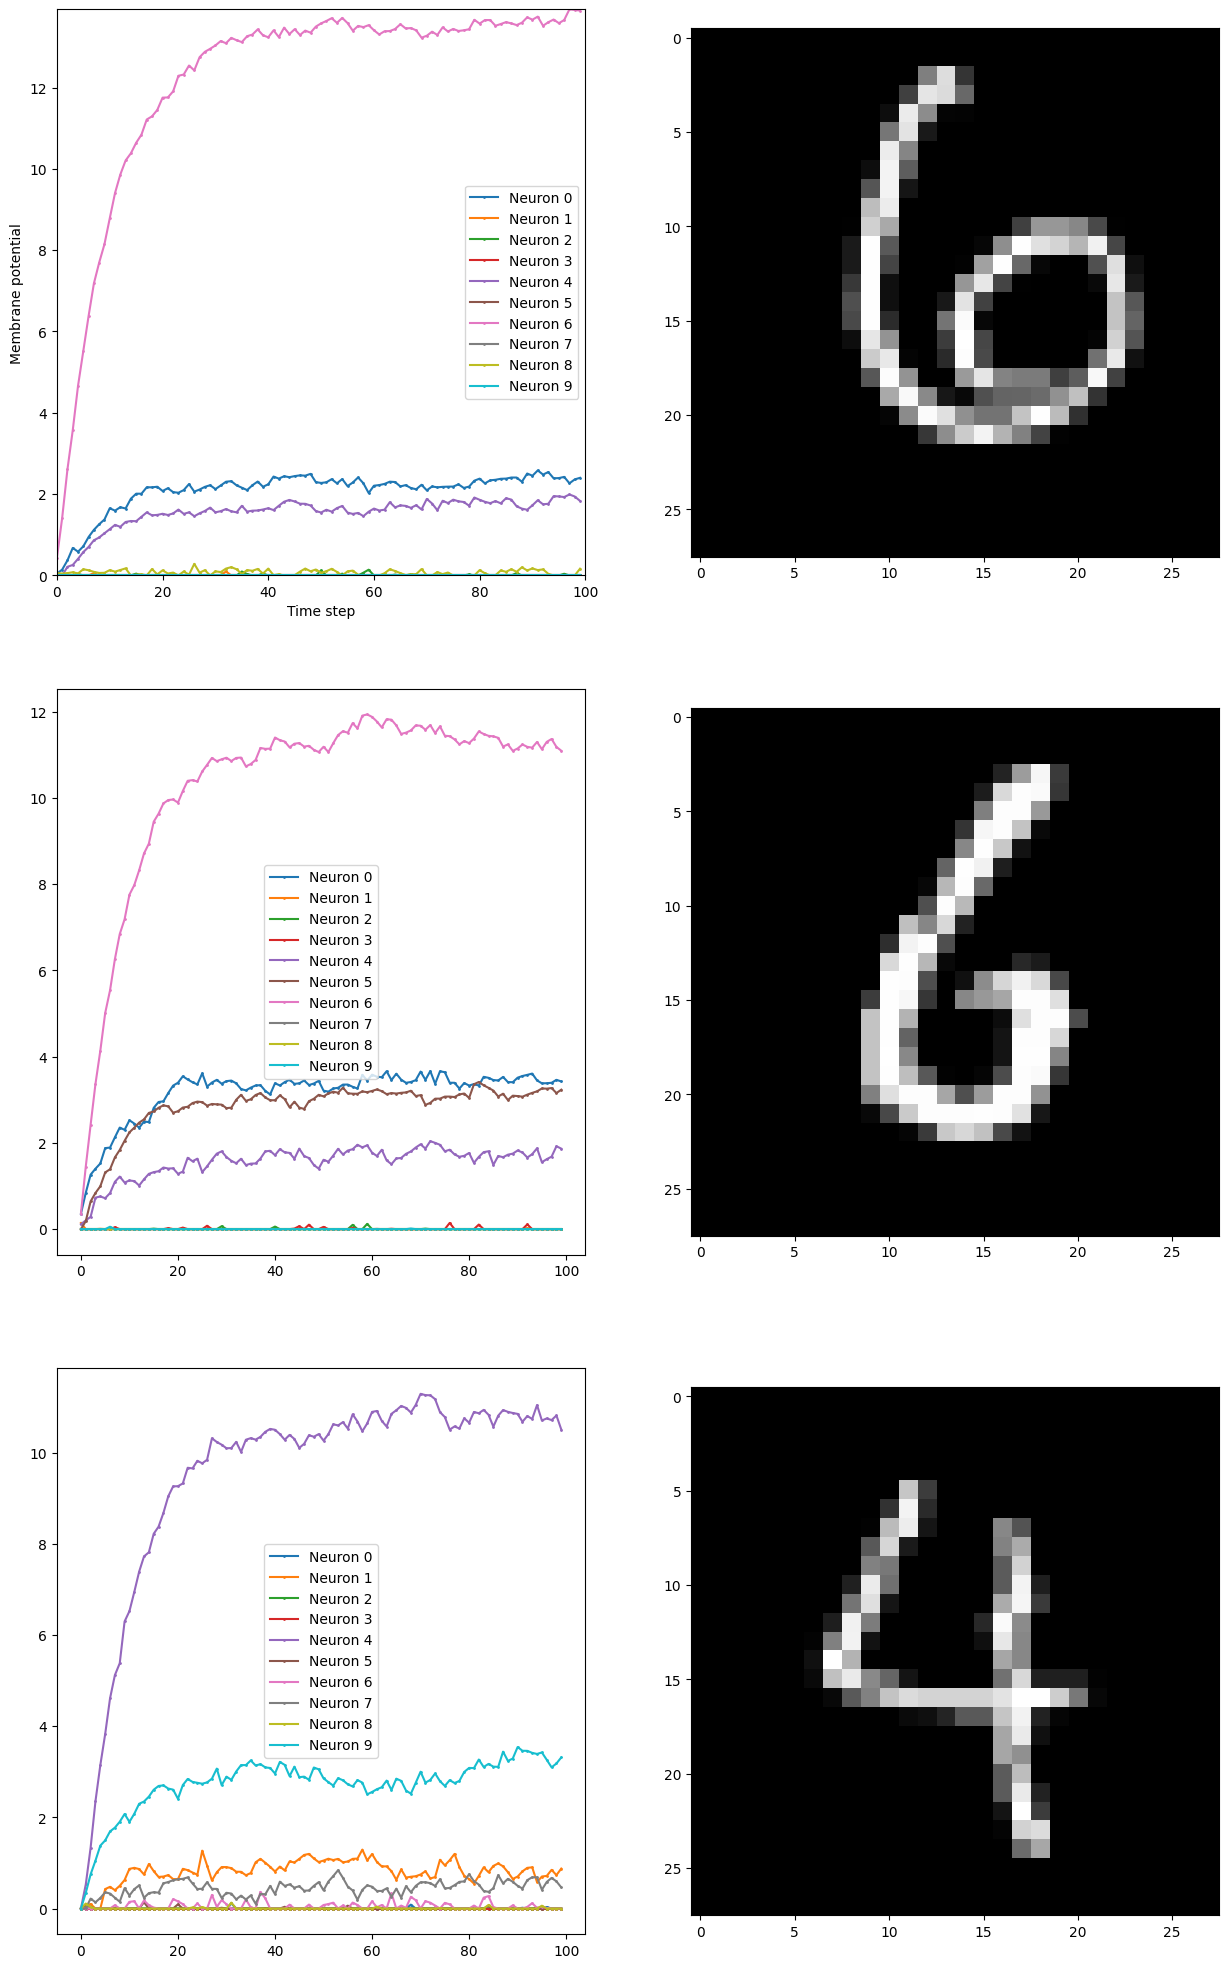

In [23]:
# get V_mem_data for one test image
img_b_test, lbl_b_test = next(iter(test_loader_unencoded))
img_b_test_e, lbl_b_test_e = next(iter(test_loader))

id1 = 100
id2 = 50
id3 = 24

V_mem_data1 = V_mem_from_img_id(id1, params_final, test_loader_unencoded)
V_mem_data2 = V_mem_from_img_id(id2, params_final, test_loader_unencoded)
V_mem_data3 = V_mem_from_img_id(id3, params_final, test_loader_unencoded)

test_img1 = img_b_test[id1]
test_img2 = img_b_test[id2]
test_img3 = img_b_test[id3]

# for all V_mem_data, plot the 10 diferent membrane potentials in a single plot and next to it plot the corresponding input image
fig, ax = plt.subplots(3, 2, figsize=(1500*px, 2500*px))
xs = jnp.arange(100)
y_max = V_mem_data1.max(axis=0).max(axis=0) if V_mem_data1.max(axis=0).max(axis=0) > 1.0 else 1.0
for i in range(10):
    ax[0, 0].plot(xs, V_mem_data1[:, i], label=f'Neuron {i}', marker='o', markersize=1)
    ax[1, 0].plot(xs, V_mem_data2[:, i], label=f'Neuron {i}', marker='o', markersize=1)
    ax[2, 0].plot(xs, V_mem_data3[:, i], label=f'Neuron {i}', marker='o', markersize=1)
ax[0, 0].set_xlabel('Time step')
ax[0, 0].set_ylabel('Membrane potential')
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylim(0, y_max)
# legend for every plot
ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[0, 1].imshow(test_img1.reshape(28,28), cmap='gray')
ax[1, 1].imshow(test_img2.reshape(28,28), cmap='gray')
ax[2, 1].imshow(test_img3.reshape(28,28), cmap='gray')
plt.show()

# Confusion Matrix

In [24]:
# TODO 2: implement prediction function on one image for confusion matrix
def predict_one_img(state, img):
    V_mem_data = []
    # TODO 2.1: jax scan over time steps of image using lif forward
    state, plot_values = jax.lax.scan(lif_forward,state,img)   
    # TODO 2.2: get prediction
    V_mem_data = plot_values[2]
    max_per_class = V_mem_data.max(axis=0)
    predicted_label = max_per_class.argmax()
    return predicted_label, max_per_class

v_predict_one_img = jax.vmap(predict_one_img, in_axes=(None, 0), out_axes=0)

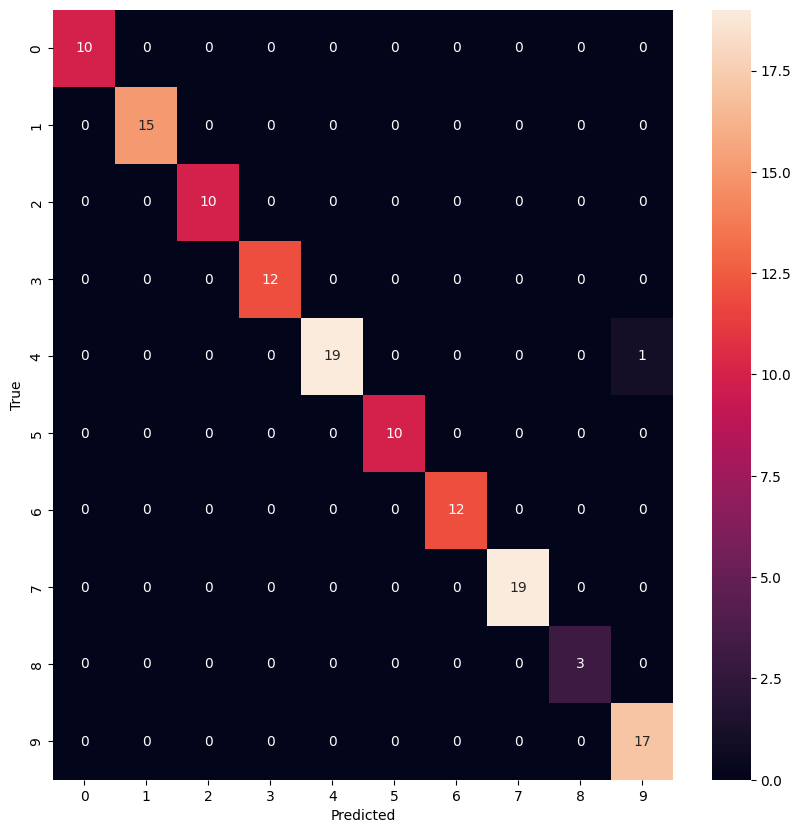

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

img_b_test_e, lbl_b_test_e = next(iter(test_loader))

# initialize state variables and state
V_mem1 = jnp.zeros((num_hidden,), dtype='float32')
I_in = jnp.zeros((num_hidden,), dtype='float32')
hidden_spikes = jnp.zeros((num_hidden,), dtype='float32')
V_mem2 = jnp.zeros((num_classes,), dtype='float32')
out_spikes = jnp.zeros((num_classes,), dtype='float32')

state = ((params_final, hidden_spikes, out_spikes, I_in, V_mem1, V_mem2), static_params)

prediction_test, max_per_class = v_predict_one_img(state, img_b_test_e)

# get the confusion matrix
cm = confusion_matrix(lbl_b_test_e, prediction_test)

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(lbl_b_test_e, prediction_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00        12
         4.0       1.00      0.95      0.97        20
         5.0       1.00      1.00      1.00        10
         6.0       1.00      1.00      1.00        12
         7.0       1.00      1.00      1.00        19
         8.0       1.00      1.00      1.00         3
         9.0       0.94      1.00      0.97        17

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128

